In [1]:
# importar paquetes a ocupar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio
import os

In [2]:
# importar archivos
crossBattlelog = pd.read_parquet('datasets/teams/battlelog_teams.parquet')
crossBattlelog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693410 entries, 0 to 693409
Data columns (total 44 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   battleTime                             693410 non-null  datetime64[ns]
 1   playertag                              693410 non-null  object        
 2   event_mode                             693410 non-null  object        
 3   event_map                              693410 non-null  object        
 4   battle_type                            693410 non-null  object        
 5   battle_result                          693410 non-null  object        
 6   battle_duration                        693410 non-null  int16         
 7   battle_trophyChange                    524221 non-null  float64       
 8   battle_team1_player1_tag               693410 non-null  object        
 9   battle_team1_player1_name              693408 no

In [3]:
# leer brawler stats
brawlers = pd.read_parquet('datasets/brawlers/brawlers_stats.parquet')
brawlers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              64 non-null     int64  
 1   name            64 non-null     object 
 2   starPowers.0    64 non-null     object 
 3   starPowers.1    64 non-null     object 
 4   gadgets.0       64 non-null     object 
 5   gadgets.1       64 non-null     object 
 6   Brawler         64 non-null     object 
 7   Health          64 non-null     float64
 8   Rarity          64 non-null     object 
 9   Class           64 non-null     object 
 10  Movement_Speed  64 non-null     object 
 11  Range           63 non-null     object 
 12  Reload          63 non-null     object 
 13  Speed_Num       64 non-null     int64  
 14  Range_Num       64 non-null     float64
 15  Reload_Num      63 non-null     float64
 16  Role            64 non-null     object 
dtypes: float64(3), int64(2), object(12)
m

In [4]:
# leer datos de mapa
bushList = pd.read_csv('datasets/maps/bushList.csv', index_col=0)
bushList.columns = bushList.columns.str.replace('.', '_', regex=True)
waterList = pd.read_csv('datasets/maps/waterList.csv', index_col=0)
waterList.columns = waterList.columns.str.replace('.', '_', regex=True)
barrierList = pd.read_csv('datasets/maps/barrierList.csv', index_col=0)
barrierList.columns = barrierList.columns.str.replace('.', '_', regex=True)

In [5]:
# leer brawler winrate y userate
brawler_wr_ur = pd.read_parquet('datasets/teams/brawler_winrate_userate.parquet')
brawler_wr_ur_overall = pd.read_parquet('datasets/teams/brawler_winrate_userate_overall.parquet')

In [6]:
# leer player stats
players = pd.read_parquet('datasets/players/players.parquet')

In [7]:
# función para identificar a que team pertenece el player
def team_assignment(row):
    if any(row['playertag'] == tag for tag in [row.battle_team1_player1_tag, row.battle_team1_player2_tag, row.battle_team1_player3_tag]):
        return 'team1'
    elif any(row['playertag'] == tag for tag in [row.battle_team2_player1_tag, row.battle_team2_player2_tag, row.battle_team2_player3_tag]):
        return 'team2'
    else:
        return "error in team assignation for id " + str(row.name)

crossBattlelog['player_team'] = crossBattlelog.apply(team_assignment, axis=1)

crossBattlelog['player_team'].value_counts()

team2    351342
team1    342068
Name: player_team, dtype: int64

In [8]:
# eliminar draws, no aportan al modelo
crossBattlelog = crossBattlelog[crossBattlelog['battle_result'] != 'draw'].reset_index(drop=True)

In [9]:
# crear columna winner_team
def winner_assignment(row):
	if row.battle_result == 'draw':
		return 'draw'
	elif (row.player_team == 'team1' and row.battle_result == 'victory') or (row.player_team == 'team2' and row.battle_result == 'defeat'):
		return 'team1'
	elif (row.player_team == 'team2' and row.battle_result == 'victory') or (row.player_team == 'team1' and row.battle_result == 'defeat'):
		return 'team2'
	else:
		return "error in winner assignation for id " + str(row.name)

crossBattlelog['winner_team'] = crossBattlelog.apply(winner_assignment, axis=1)

crossBattlelog['winner_team'].value_counts()

team1    344627
team2    344154
Name: winner_team, dtype: int64

In [11]:
# crear columna winner
def subset_winner(df, team):

	df['winner'] = 'no'

	for i, winner_team in enumerate(df['winner_team']):
		if winner_team == team:
			df.loc[i, 'winner'] = 'yes'

	df = df.rename(columns={
		'battle_' + team + '_player1_tag': 'battle_player1_tag'
		,'battle_' + team + '_player1_brawler_name': 'battle_player1_brawler_name'
		,'battle_' + team + '_player1_brawler_power': 'battle_player1_brawler_power'
		,'battle_' + team + '_player1_brawler_trophies': 'battle_player1_brawler_trophies'
		,'battle_' + team + '_player2_tag': 'battle_player2_tag'
		,'battle_' + team + '_player2_brawler_name': 'battle_player2_brawler_name'
		,'battle_' + team + '_player2_brawler_power': 'battle_player2_brawler_power'
		,'battle_' + team + '_player2_brawler_trophies': 'battle_player2_brawler_trophies'
		,'battle_' + team + '_player3_tag': 'battle_player3_tag'
		,'battle_' + team + '_player3_brawler_name': 'battle_player3_brawler_name'
		,'battle_' + team + '_player3_brawler_power': 'battle_player3_brawler_power'
		,'battle_' + team + '_player3_brawler_trophies': 'battle_player3_brawler_trophies'
	})

	df = df[[	
		'event_mode'
		,'event_map'
		,'battle_type'
		,'battle_duration'
		,'battle_player1_tag'
		,'battle_player1_brawler_name'
		,'battle_player1_brawler_power'
		,'battle_player1_brawler_trophies'
		,'battle_player2_tag'
		,'battle_player2_brawler_name'
		,'battle_player2_brawler_power'
		,'battle_player2_brawler_trophies'
		,'battle_player3_tag'
		,'battle_player3_brawler_name'
		,'battle_player3_brawler_power'
		,'battle_player3_brawler_trophies'
		,'winner'
	]]

	return df

def clean_winner(team):

	if team == 'team1':
		oteam = 'team2'
	else:
		oteam = 'team1'
	
	subset = crossBattlelog[crossBattlelog['winner_team'] == team].reset_index(drop=True)

	dfwinners = subset_winner(subset, team)

	dfloosers = subset_winner(subset, oteam)

	return pd.concat([dfwinners, dfloosers], ignore_index=True)

team1 = clean_winner('team1')
team2 = clean_winner('team2')

battlelogProcess = pd.concat([team1, team2], ignore_index=True)
battlelogProcess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1377562 entries, 0 to 1377561
Data columns (total 17 columns):
 #   Column                           Non-Null Count    Dtype 
---  ------                           --------------    ----- 
 0   event_mode                       1377562 non-null  object
 1   event_map                        1377562 non-null  object
 2   battle_type                      1377562 non-null  object
 3   battle_duration                  1377562 non-null  int16 
 4   battle_player1_tag               1377562 non-null  object
 5   battle_player1_brawler_name      1377562 non-null  object
 6   battle_player1_brawler_power     1377562 non-null  int8  
 7   battle_player1_brawler_trophies  1377562 non-null  int16 
 8   battle_player2_tag               1377562 non-null  object
 9   battle_player2_brawler_name      1377562 non-null  object
 10  battle_player2_brawler_power     1377562 non-null  int8  
 11  battle_player2_brawler_trophies  1377562 non-null  int16 
 12  

In [102]:
# merge brawler stats
battlelogFinal = battlelogProcess

def add_brawlers(df, prefix):
	df = pd.merge(left=df, right=brawlers[['name','Health','Rarity','Class','Movement_Speed','Range','Reload','Speed_Num','Range_Num','Reload_Num','Role']].add_prefix(prefix), on=prefix + 'name', how='left', suffixes=('','_b'))
	return df

battlelogFinal = add_brawlers(battlelogFinal, 'battle_player1_brawler_')
battlelogFinal = add_brawlers(battlelogFinal, 'battle_player2_brawler_')
battlelogFinal = add_brawlers(battlelogFinal, 'battle_player3_brawler_')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1377562 entries, 0 to 1377561
Data columns (total 47 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   event_mode                             1377562 non-null  object 
 1   event_map                              1377562 non-null  object 
 2   battle_type                            1377562 non-null  object 
 3   battle_duration                        1377562 non-null  int16  
 4   battle_player1_tag                     1377562 non-null  object 
 5   battle_player1_brawler_name            1377562 non-null  object 
 6   battle_player1_brawler_power           1377562 non-null  int8   
 7   battle_player1_brawler_trophies        1377562 non-null  int16  
 8   battle_player2_tag                     1377562 non-null  object 
 9   battle_player2_brawler_name            1377562 non-null  object 
 10  battle_player2_brawler_power           137

In [103]:
# merge player stats
def merge_playerstats(df, prefix):
	df = pd.merge(left=df, right=players.add_prefix(prefix), on=prefix + 'tag', how='inner')
	return df

battlelogFinal = merge_playerstats(battlelogFinal, 'battle_player1_')
battlelogFinal = merge_playerstats(battlelogFinal, 'battle_player2_')
battlelogFinal = merge_playerstats(battlelogFinal, 'battle_player3_')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1373294 entries, 0 to 1373293
Data columns (total 62 columns):
 #   Column                                 Non-Null Count    Dtype         
---  ------                                 --------------    -----         
 0   event_mode                             1373294 non-null  object        
 1   event_map                              1373294 non-null  object        
 2   battle_type                            1373294 non-null  object        
 3   battle_duration                        1373294 non-null  int16         
 4   battle_player1_tag                     1373294 non-null  object        
 5   battle_player1_brawler_name            1373294 non-null  object        
 6   battle_player1_brawler_power           1373294 non-null  int8          
 7   battle_player1_brawler_trophies        1373294 non-null  int16         
 8   battle_player2_tag                     1373294 non-null  object        
 9   battle_player2_brawler_name        

In [104]:
# merge map data
battlelogFinal = battlelogFinal.merge(barrierList, how='inner', on='event_map')
battlelogFinal = battlelogFinal.merge(bushList, how='inner', on='event_map')
battlelogFinal = battlelogFinal.merge(waterList, how='left', on='event_map')
battlelogFinal['waterProp'] = battlelogFinal['waterProp'].fillna(0)
battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1373294 entries, 0 to 1373293
Data columns (total 67 columns):
 #   Column                                 Non-Null Count    Dtype         
---  ------                                 --------------    -----         
 0   event_mode                             1373294 non-null  object        
 1   event_map                              1373294 non-null  object        
 2   battle_type                            1373294 non-null  object        
 3   battle_duration                        1373294 non-null  int16         
 4   battle_player1_tag                     1373294 non-null  object        
 5   battle_player1_brawler_name            1373294 non-null  object        
 6   battle_player1_brawler_power           1373294 non-null  int8          
 7   battle_player1_brawler_trophies        1373294 non-null  int16         
 8   battle_player2_tag                     1373294 non-null  object        
 9   battle_player2_brawler_name        

In [105]:
# merge winrate y userate
def add_wr_ur(df, prefix):
	df = pd.merge(
		left=df
		,right=brawler_wr_ur[['brawlername', 'event_mode', 'event_map', 'winrate', 'userate', 'percentile_quadrant']].add_prefix(prefix)
		,left_on=[prefix + 'name', 'event_mode', 'event_map']
		,right_on=[prefix + 'brawlername', prefix + 'event_mode', prefix + 'event_map']
		,how='left'
		,suffixes=('','_w'))
	return df

battlelogFinal = add_wr_ur(battlelogFinal, 'battle_player1_brawler_')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle_player2_brawler_')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle_player3_brawler_')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1373294 entries, 0 to 1373293
Data columns (total 85 columns):
 #   Column                                      Non-Null Count    Dtype         
---  ------                                      --------------    -----         
 0   event_mode                                  1373294 non-null  object        
 1   event_map                                   1373294 non-null  object        
 2   battle_type                                 1373294 non-null  object        
 3   battle_duration                             1373294 non-null  int16         
 4   battle_player1_tag                          1373294 non-null  object        
 5   battle_player1_brawler_name                 1373294 non-null  object        
 6   battle_player1_brawler_power                1373294 non-null  int8          
 7   battle_player1_brawler_trophies             1373294 non-null  int16         
 8   battle_player2_tag                          1373294 non-null  

In [106]:
# merge winrate y userate overall
def add_wr_ur_oa(df, prefix):
	df = pd.merge(
		left=df
		,right=brawler_wr_ur_overall[['brawlername', 'winrate', 'userate', 'percentile_quadrant']].add_prefix(prefix)
		,left_on=[prefix + 'name']
		,right_on=[prefix + 'brawlername']
		,how='left'
		,suffixes=('','_overall'))
	return df

battlelogFinal = add_wr_ur_oa(battlelogFinal, 'battle_player1_brawler_')
battlelogFinal = add_wr_ur_oa(battlelogFinal, 'battle_player2_brawler_')
battlelogFinal = add_wr_ur_oa(battlelogFinal, 'battle_player3_brawler_')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1373294 entries, 0 to 1373293
Data columns (total 97 columns):
 #   Column                                              Non-Null Count    Dtype         
---  ------                                              --------------    -----         
 0   event_mode                                          1373294 non-null  object        
 1   event_map                                           1373294 non-null  object        
 2   battle_type                                         1373294 non-null  object        
 3   battle_duration                                     1373294 non-null  int16         
 4   battle_player1_tag                                  1373294 non-null  object        
 5   battle_player1_brawler_name                         1373294 non-null  object        
 6   battle_player1_brawler_power                        1373294 non-null  int8          
 7   battle_player1_brawler_trophies                     1373294 non-null  in

In [107]:
plt.style.use('ggplot')

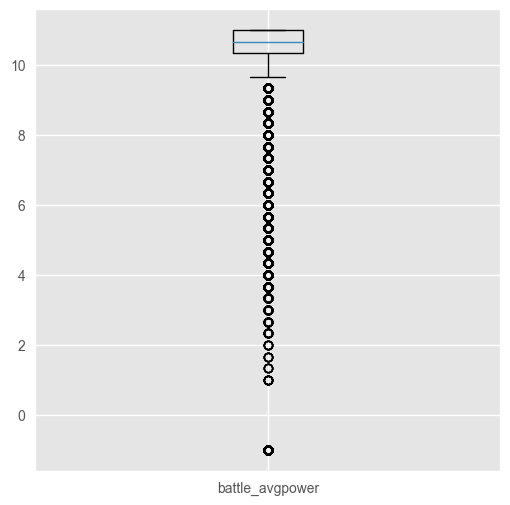

In [108]:
# crear columna avg power
def create_avg(row, column):
    return (row['battle_player1_'+ column] + row['battle_player2_'+ column] + row['battle_player3_'+ column]) / 3

def create_boxplots(df, col1):
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)
    ax.boxplot(df[col1])
    ax.set_xticklabels([col1])
    plt.show()

battlelogFinal['battle_avgpower'] = battlelogFinal.apply(lambda row: create_avg(row, 'brawler_power'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgpower'].isna() == False]

create_boxplots(battlelogFinal, 'battle_avgpower')

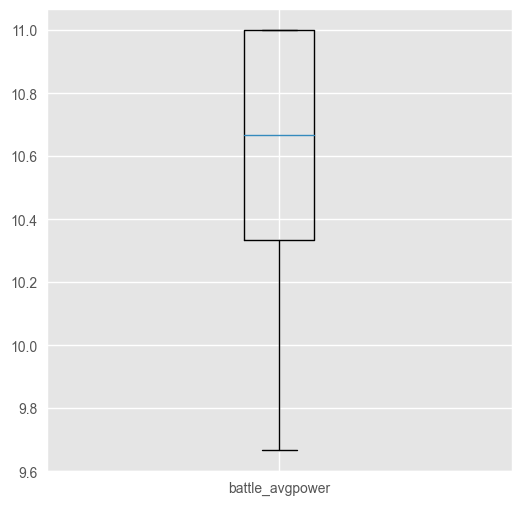

In [109]:
# subset avg power
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgpower'] > 9.5].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgpower')

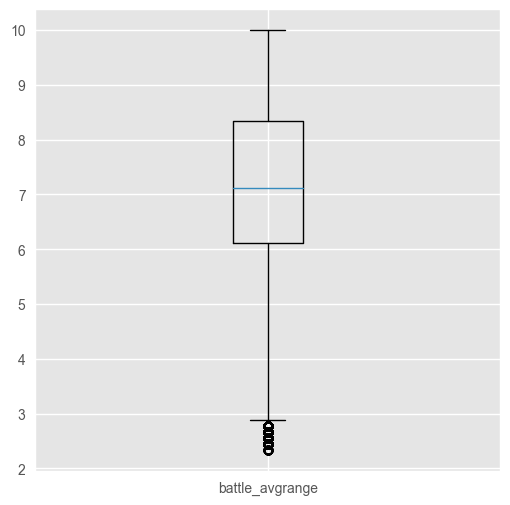

In [110]:
# crear columna avg range
battlelogFinal['battle_avgrange'] = battlelogFinal.apply(lambda row: create_avg(row, 'brawler_Range_Num'), axis=1)

create_boxplots(battlelogFinal, 'battle_avgrange')

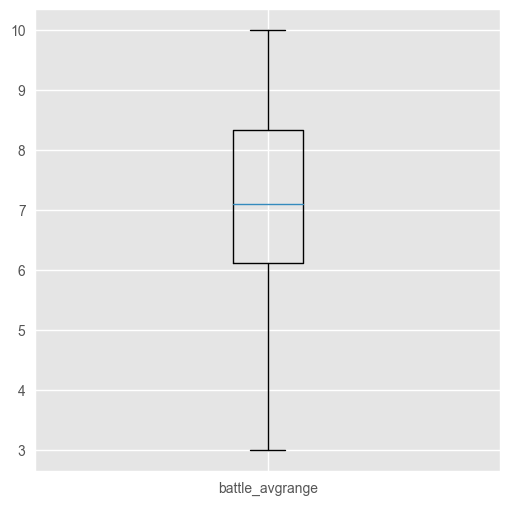

In [111]:
# subset avg range
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgrange'] > 2.9].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgrange')

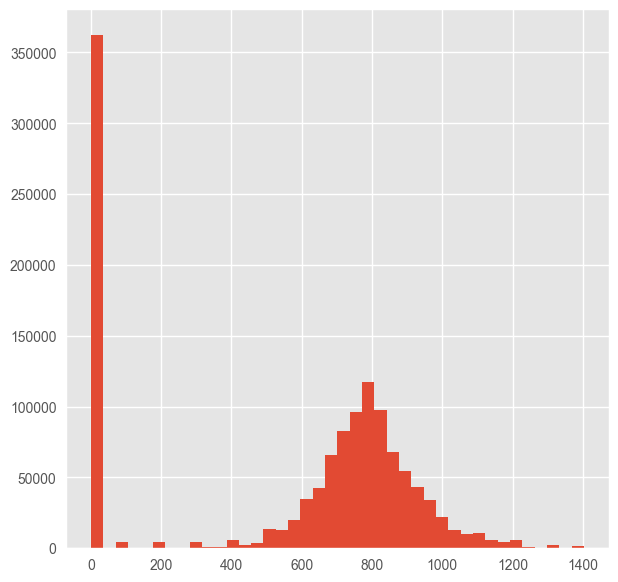

In [112]:
# crear columna avg brawler trophies
battlelogFinal['battle_avgbrawlertrophies'] = battlelogFinal.apply(lambda row: create_avg(row, 'brawler_trophies'), axis=1)

fig, ax = plt.subplots(figsize=(7,7))
ax.hist(x=battlelogFinal['battle_avgbrawlertrophies'], bins=40)
plt.show()

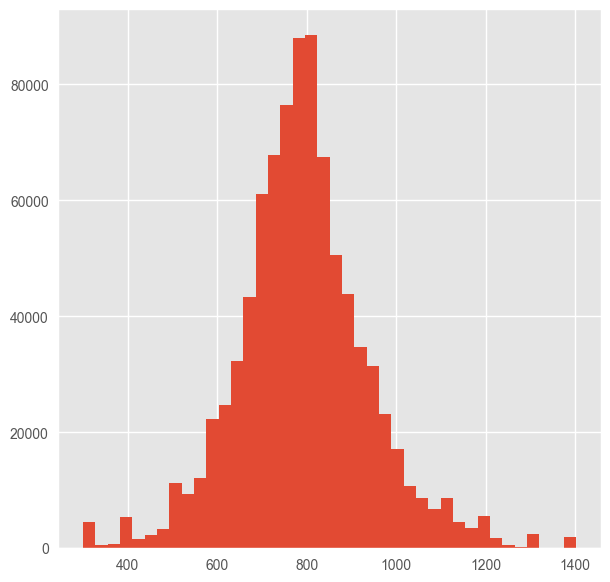

In [113]:
# subset avg trophies
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgbrawlertrophies'] >= 300].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(7,7))
ax.hist(x=battlelogFinal['battle_avgbrawlertrophies'], bins=40)
plt.show()

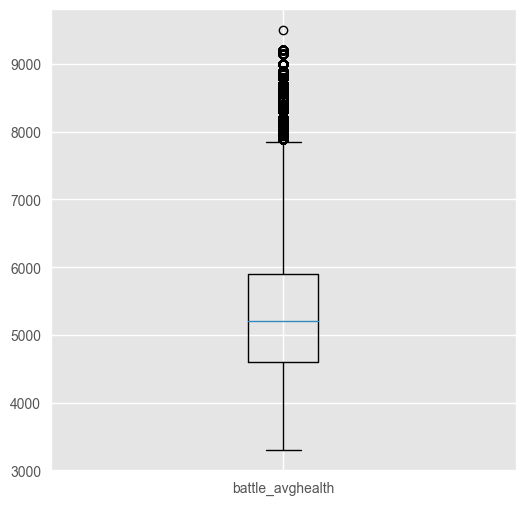

In [114]:
# crear columna avg health
battlelogFinal['battle_avghealth'] = battlelogFinal.apply(lambda row: create_avg(row, 'brawler_Health'), axis=1).reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avghealth')

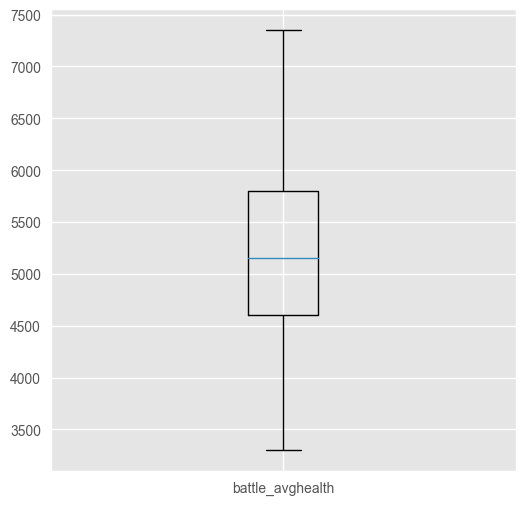

In [115]:
# subset avg health
battlelogFinal = battlelogFinal[battlelogFinal['battle_avghealth'] < 7800].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avghealth')

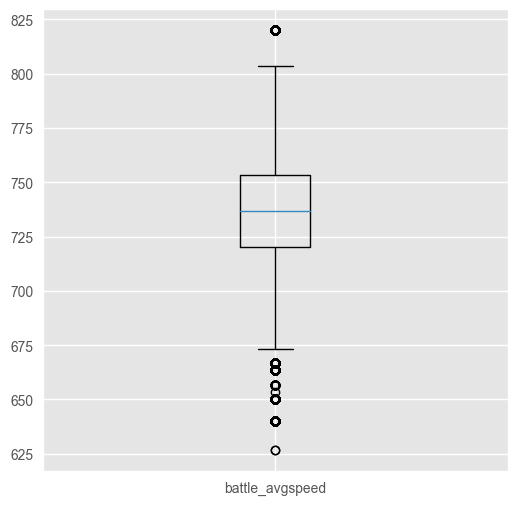

In [116]:
# crear columna avg speed
battlelogFinal['battle_avgspeed'] = battlelogFinal.apply(lambda row: create_avg(row, 'brawler_Speed_Num'), axis=1)

create_boxplots(battlelogFinal, 'battle_avgspeed')

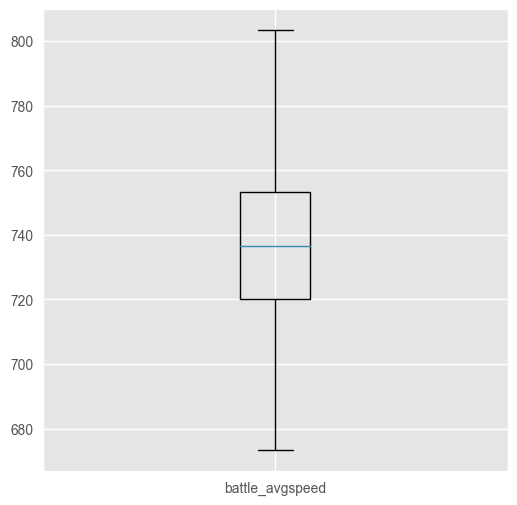

In [117]:
# subset avg speed
battlelogFinal = battlelogFinal[(battlelogFinal['battle_avgspeed'] >= 670) & (battlelogFinal['battle_avgspeed'] <= 810)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgspeed')

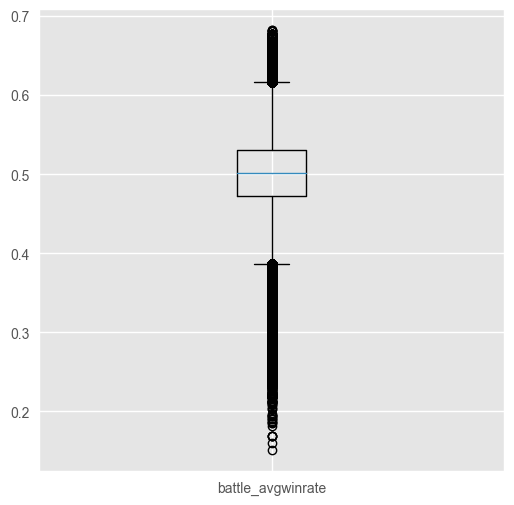

In [118]:
# crear columna avg winrate
battlelogFinal['battle_avgwinrate'] = battlelogFinal.apply(lambda row: create_avg(row, 'brawler_winrate'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgwinrate'].isna() == False]

create_boxplots(battlelogFinal, 'battle_avgwinrate')

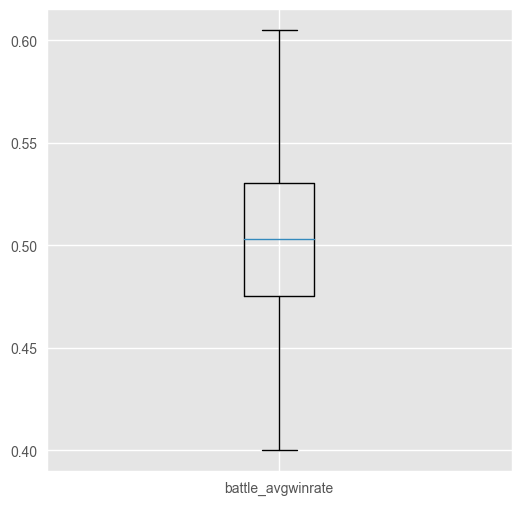

In [119]:
# subset avg winrate
battlelogFinal = battlelogFinal[(battlelogFinal['battle_avgwinrate'] >= 0.4) & (battlelogFinal['battle_avgwinrate'] <= 0.605)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgwinrate')

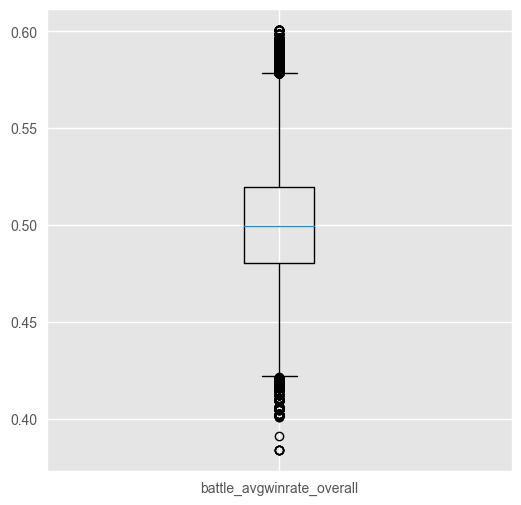

In [120]:
# crear columna avg winrate
battlelogFinal['battle_avgwinrate_overall'] = battlelogFinal.apply(lambda row: create_avg(row, 'brawler_winrate_overall'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgwinrate_overall'].isna() == False]

create_boxplots(battlelogFinal, 'battle_avgwinrate_overall')

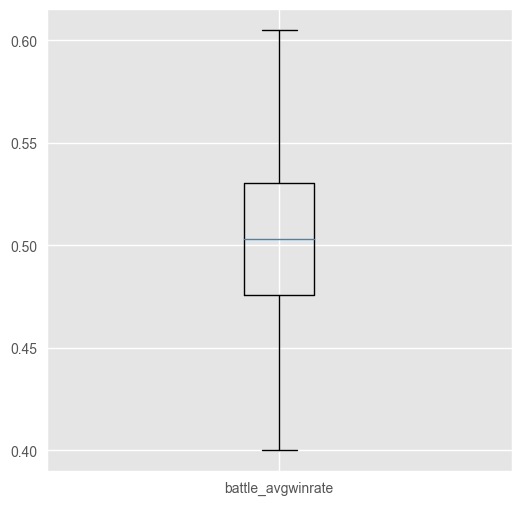

In [121]:
# subset avg winrate overall
battlelogFinal = battlelogFinal[(battlelogFinal['battle_avgwinrate_overall'] >= 0.43) & (battlelogFinal['battle_avgwinrate_overall'] <= 0.59)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgwinrate')

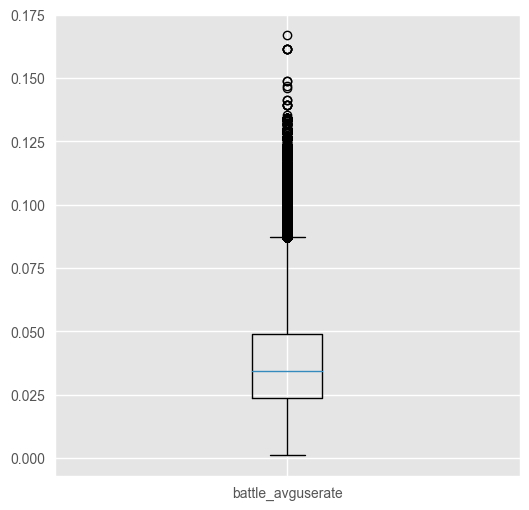

In [122]:
# crear columna avg userate
battlelogFinal['battle_avguserate'] = battlelogFinal.apply(lambda row: create_avg(row, 'brawler_userate'), axis=1)

create_boxplots(battlelogFinal, 'battle_avguserate')

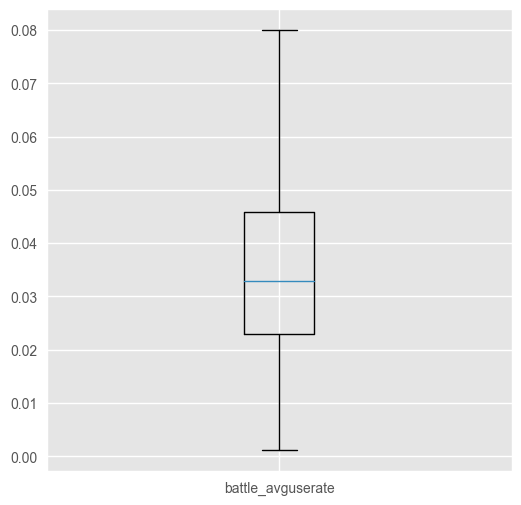

In [123]:
# subset avg userate
battlelogFinal = battlelogFinal[battlelogFinal['battle_avguserate'] <= 0.08].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avguserate')

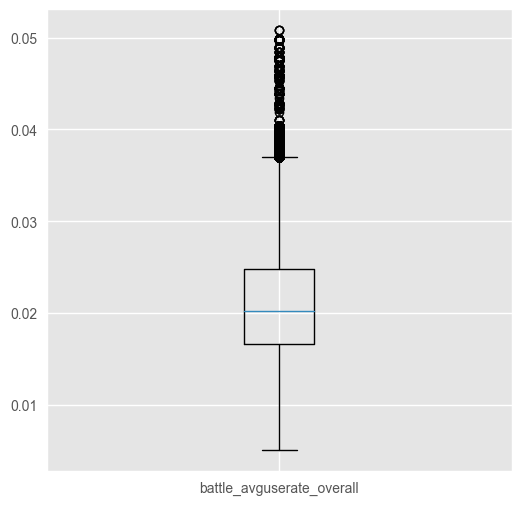

In [124]:
# crear columna avg userate overall
battlelogFinal['battle_avguserate_overall'] = battlelogFinal.apply(lambda row: create_avg(row, 'brawler_userate_overall'), axis=1)

create_boxplots(battlelogFinal, 'battle_avguserate_overall')

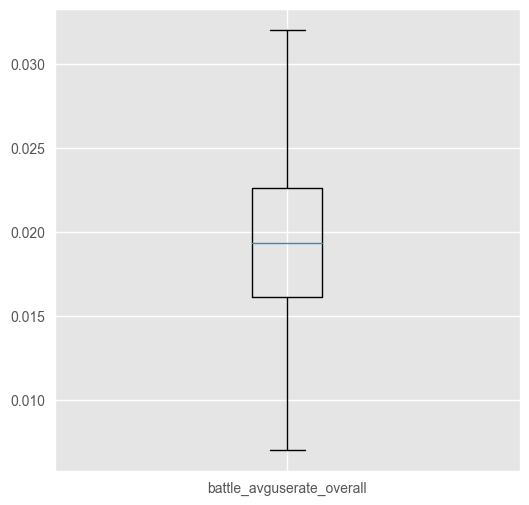

In [125]:
# subset avg userate overall
battlelogFinal = battlelogFinal[(battlelogFinal['battle_avguserate_overall'] <= 0.032) & (battlelogFinal['battle_avguserate_overall'] >= 0.007)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avguserate_overall')

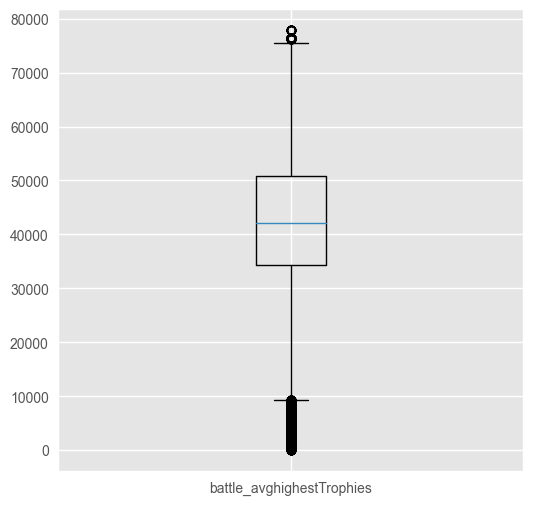

In [126]:
# crear columna avg highestTrophies
battlelogFinal['battle_avghighestTrophies'] = battlelogFinal.apply(lambda row: create_avg(row, 'highestTrophies'), axis=1)

create_boxplots(battlelogFinal, 'battle_avghighestTrophies')

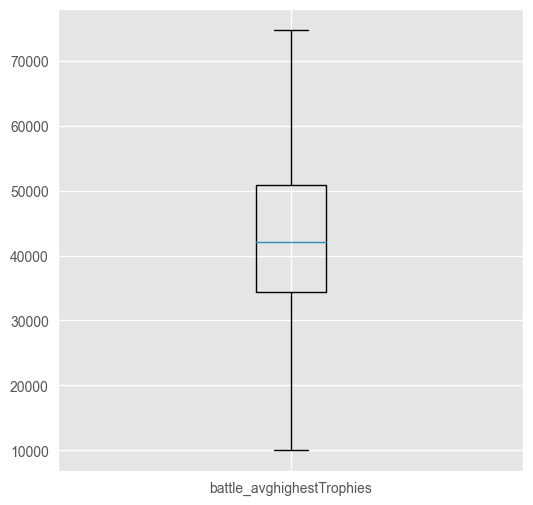

In [128]:
# subset avg highestTrophies
battlelogFinal = battlelogFinal[(battlelogFinal['battle_avghighestTrophies'] >= 10000) & (battlelogFinal['battle_avghighestTrophies'] <= 75000)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avghighestTrophies')

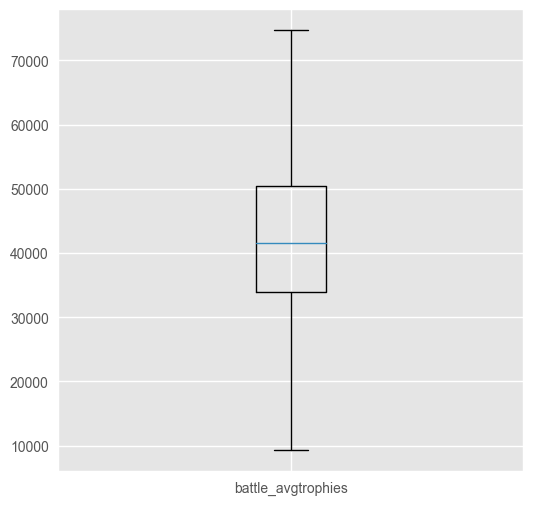

In [129]:
# crear columna avg trophies
battlelogFinal['battle_avgtrophies'] = battlelogFinal.apply(lambda row: create_avg(row, 'trophies'), axis=1)

create_boxplots(battlelogFinal, 'battle_avgtrophies')

In [ ]:
# subset avg trophies
# battlelogFinal = battlelogFinal[(battlelogFinal['battle_avgtrophies'] >= 10000) & (battlelogFinal['battle_avgtrophies'] <= 75000)].reset_index(drop=True)

# create_boxplots(battlelogFinal, 'battle_avgtrophies')

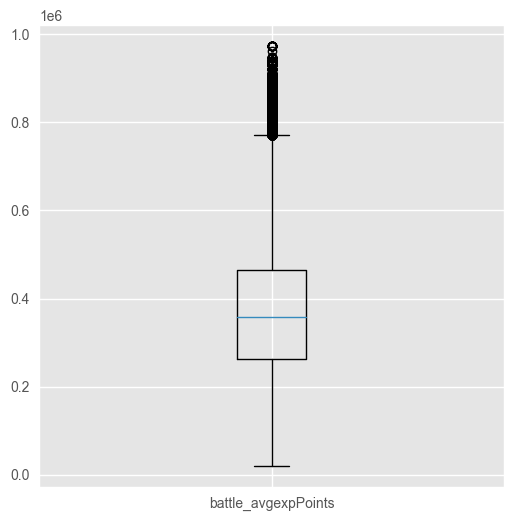

In [130]:
# crear columna avg expPoints
battlelogFinal['battle_avgexpPoints'] = battlelogFinal.apply(lambda row: create_avg(row, 'expPoints'), axis=1)

create_boxplots(battlelogFinal, 'battle_avgexpPoints')

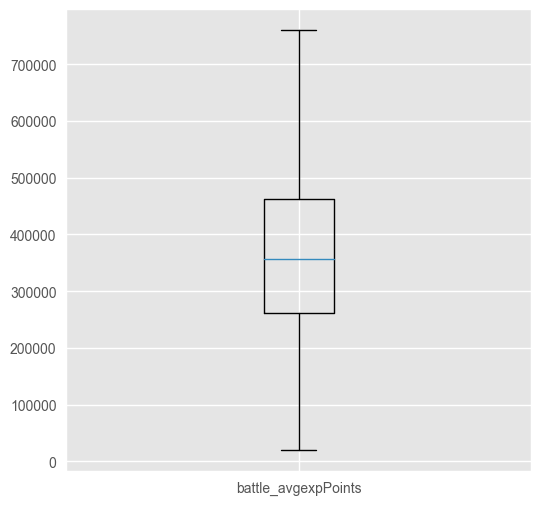

In [134]:
# subset avg expPoints
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgexpPoints'] <= 760_000].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgexpPoints')

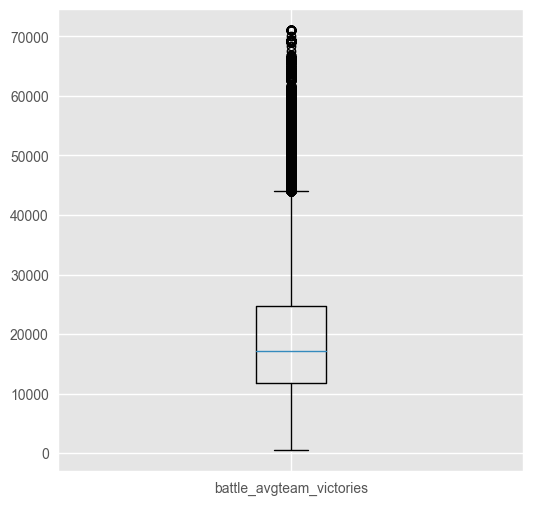

In [135]:
# crear columna avg team_victories
battlelogFinal['battle_avgteam_victories'] = battlelogFinal.apply(lambda row: create_avg(row, 'team_victories'), axis=1)

create_boxplots(battlelogFinal, 'battle_avgteam_victories')

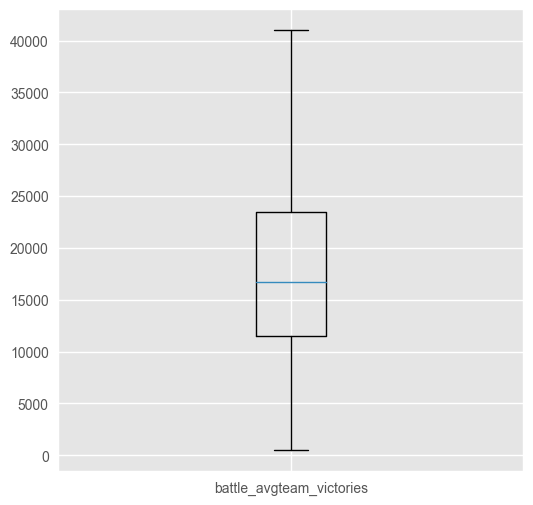

In [139]:
# subset avg team_victories
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgteam_victories'] <= 41_000].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgteam_victories')

In [140]:
# best brawlers
def get_min_max_rest(row, column_names):
    a, b, c = row[column_names[0]], row[column_names[1]], row[column_names[2]]
    min_val = min(a, b, c)
    max_val = max(a, b, c)
    rest_val = (a + b + c) - min_val - max_val
    return min_val, max_val, rest_val

def order_rows(df, column):
	column_names = ['battle_player1_' + column, 'battle_player2_' + column, 'battle_player3_' + column]
	min_vals, max_vals, rest_vals = zip(*df.apply(lambda x: get_min_max_rest(x, column_names), axis=1))
	df['battle_' + column + '_min'] = min_vals
	df['battle_' + column + '_max'] = max_vals
	df['battle_' + column + '_med'] = rest_vals
	return df

In [146]:
battlelogFinal = order_rows(battlelogFinal, 'brawler_power')
battlelogFinal = order_rows(battlelogFinal, 'brawler_trophies')
battlelogFinal = order_rows(battlelogFinal, 'brawler_Health')
battlelogFinal = order_rows(battlelogFinal, 'brawler_Range_Num')
battlelogFinal = order_rows(battlelogFinal, 'brawler_Speed_Num')
battlelogFinal = order_rows(battlelogFinal, 'brawler_winrate')
battlelogFinal = order_rows(battlelogFinal, 'brawler_userate')
battlelogFinal = order_rows(battlelogFinal, 'brawler_winrate_overall')
battlelogFinal = order_rows(battlelogFinal, 'brawler_userate_overall')
battlelogFinal = order_rows(battlelogFinal, 'trophies')
battlelogFinal = order_rows(battlelogFinal, 'highestTrophies')
battlelogFinal = order_rows(battlelogFinal, 'expPoints')
battlelogFinal = order_rows(battlelogFinal, 'team_victories')

In [147]:
battlelogFinal.shape

(635974, 149)

In [150]:
# definición final de columnas
def subset_battlelog(gamemode):

	df = subset_complete()[battlelogFinal['event_mode'] == gamemode].reset_index(drop=True)

	return df

def subset_complete():
	df = battlelogFinal[[
	'winner'
	,'event_mode'
	,'event_map'
	,'battle_avgpower'
	,'battle_brawler_power_min'
	,'battle_brawler_power_max'
	,'battle_avgbrawlertrophies'
	,'battle_brawler_trophies_min'
	,'battle_brawler_trophies_max'
	,'battle_avgtrophies'
	,'battle_trophies_min'
	,'battle_trophies_max'
	,'battle_avghighestTrophies'
	,'battle_highestTrophies_min'
	,'battle_highestTrophies_max'
	,'battle_avghealth'
	,'battle_brawler_Health_min'
	,'battle_brawler_Health_max'
	,'battle_avgrange'
	,'battle_brawler_Range_Num_min'
	,'battle_brawler_Range_Num_max'
	,'battle_avgspeed'
	,'battle_brawler_Speed_Num_min'
	,'battle_brawler_Speed_Num_max'
	,'battle_avgwinrate'
	,'battle_brawler_winrate_min'
	,'battle_brawler_winrate_max'
	,'battle_avgwinrate_overall'
	,'battle_brawler_winrate_overall_min'
	,'battle_brawler_winrate_overall_max'
	,'battle_avguserate'
	,'battle_brawler_userate_min'
	,'battle_brawler_userate_max'
	,'battle_avguserate_overall'
	,'battle_brawler_userate_overall_min'
	,'battle_brawler_userate_overall_max'
	,'battle_avgteam_victories'
	,'battle_team_victories_min'
	,'battle_team_victories_max'
	,'battle_avgexpPoints'
	,'battle_expPoints_min'
	,'battle_expPoints_max'
	]].reset_index(drop=True)
	
	df['winner'] = df['winner'].replace({'yes': 1, 'no': 0}).astype(int)

	df['battle_avgbrawlertrophies'] = np.log(df['battle_avgtrophies'])
	df['battle_brawler_trophies_min'] = np.log(df['battle_brawler_trophies_min'])
	df['battle_brawler_trophies_max'] = np.log(df['battle_brawler_trophies_max'])
	df['battle_avgtrophies'] = np.log(df['battle_avgtrophies'])
	df['battle_trophies_min'] = np.log(df['battle_trophies_min'])
	df['battle_trophies_max'] = np.log(df['battle_trophies_max'])
	df['battle_avghighestTrophies'] = np.log(df['battle_avghighestTrophies'])
	df['battle_highestTrophies_min'] = np.log(df['battle_highestTrophies_min'])
	df['battle_highestTrophies_max'] = np.log(df['battle_highestTrophies_max'])
	df['battle_avghealth'] = np.log(df['battle_avghealth'])
	df['battle_brawler_Health_min'] = np.log(df['battle_brawler_Health_min'])
	df['battle_brawler_Health_max'] = np.log(df['battle_brawler_Health_max'])
	df['battle_avgspeed'] = np.log(df['battle_avgspeed'])
	df['battle_brawler_Speed_Num_min'] = np.log(df['battle_brawler_Speed_Num_min'])
	df['battle_brawler_Speed_Num_max'] = np.log(df['battle_brawler_Speed_Num_max'])
	df['battle_avgteam_victories'] = np.log(df['battle_avgteam_victories'])
	df['battle_team_victories_min'] = np.log(df['battle_team_victories_min'])
	df['battle_team_victories_max'] = np.log(df['battle_team_victories_max'])
	df['battle_avgexpPoints'] = np.log(df['battle_avgexpPoints'])
	df['battle_expPoints_min'] = np.log(df['battle_expPoints_min'])
	df['battle_expPoints_max'] = np.log(df['battle_expPoints_max'])

	return df

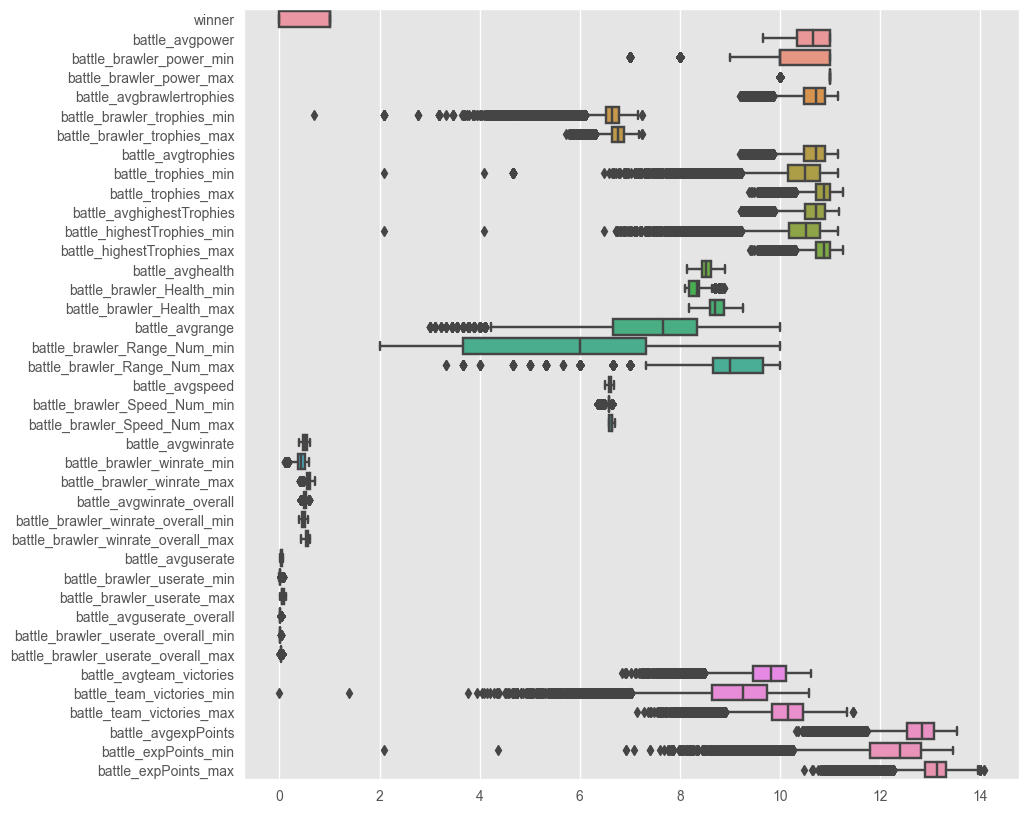

In [151]:
df = subset_battlelog('hotZone')

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data=df, orient='h', ax=ax)
plt.show()

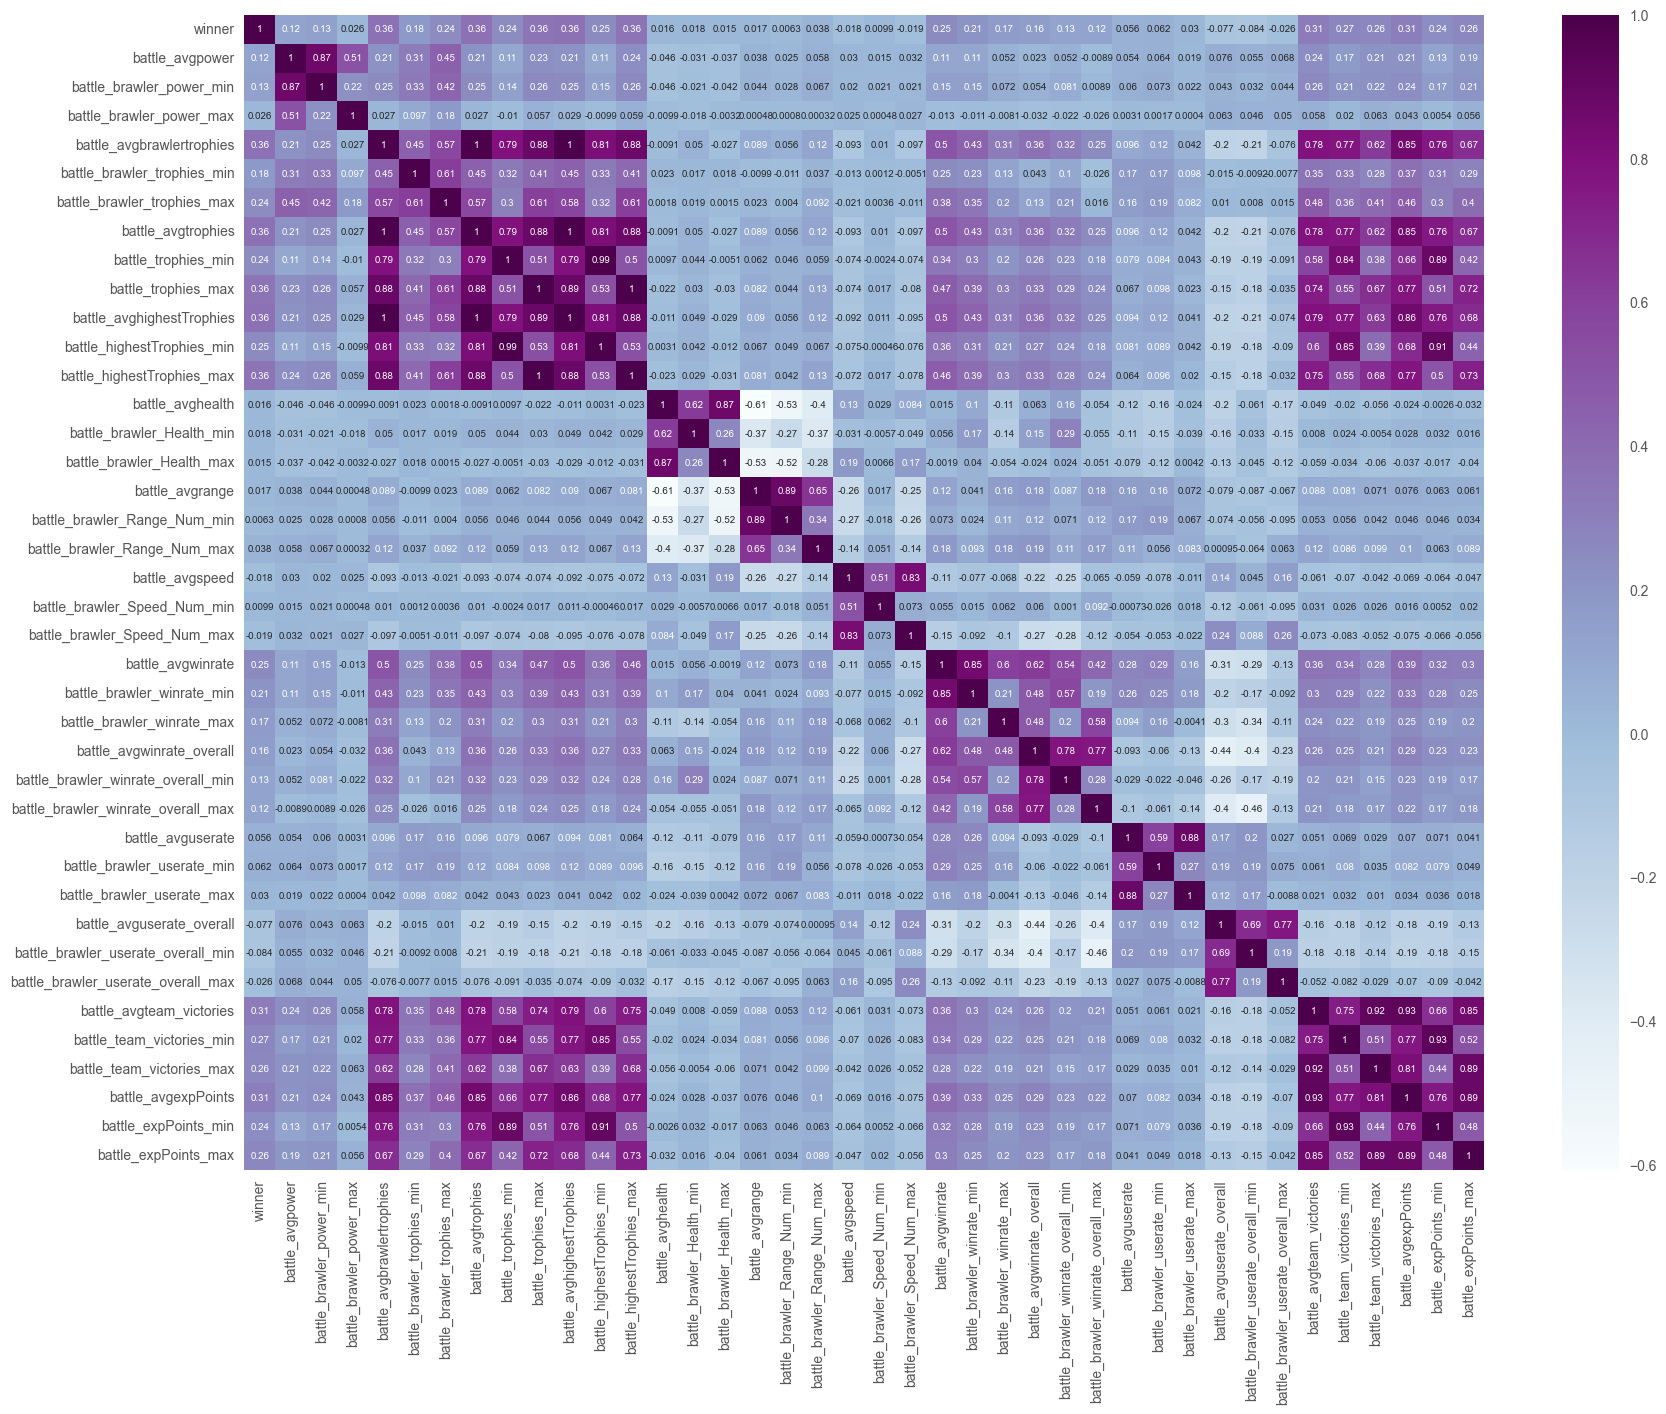

In [152]:
# heatmap de correlaciones
df = subset_battlelog('hotZone')

fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, annot_kws={"size": 7}, cmap='BuPu', ax=ax)
plt.show()

In [77]:
# completo
df = subset_complete()
df.shape

(670485, 38)

In [153]:
# cambiar working directory
print(os.getcwd())
os.chdir('machine_learning')
print(os.getcwd())

c:\Users\alniquia\OneDrive - Telefonica\Documents\Projects\BrawlStars_Model\machine_learning


FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado: 'machine_learning'

In [154]:
from pycaret.classification import *
import xgboost
import catboost
from sklearn.model_selection import train_test_split

In [155]:
# generar set de testing y training
seed=14683

train, test = train_test_split(df, test_size = 0.5, random_state=seed, stratify=df['winner'])

train.shape

(27297, 42)

In [156]:
# setup model
session_1 = setup(
	data = train,
	target = 'winner',
	fix_imbalance = True,
    feature_selection= True,
	remove_outliers=True,
	log_experiment = True,
    use_gpu=False)

,Description,Value
0,session_id,7534
1,Target,winner
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(27297, 42)"
5,Missing Values,False
6,Numeric Features,37
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [157]:
#comparación de modelos
model = compare_models(include=['rf','gbc','lightgbm','ada','catboost','xgboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6843,0.7496,0.7140,0.7063,0.7101,0.3636,0.3637,14.3030
gbc,Gradient Boosting Classifier,0.6834,0.7465,0.6939,0.7137,0.7036,0.3639,0.3642,6.2770
lightgbm,Light Gradient Boosting Machine,0.6795,0.7462,0.7075,0.7028,0.7051,0.3542,0.3542,1.5640
ada,Ada Boost Classifier,0.6764,0.7405,0.6667,0.7163,0.6906,0.3524,0.3535,2.0990
xgboost,Extreme Gradient Boosting,0.6754,0.7321,0.7074,0.6976,0.7024,0.3454,0.3455,4.5860
rf,Random Forest Classifier,0.6621,0.7182,0.6297,0.7129,0.6686,0.3267,0.3293,7.6720


In [33]:
#try model blender

# example:
# train a few models
# lr = create_model('lr')
# dt = create_model('dt')
# knn = create_model('knn')

# blend models
# blender = blend_models([lr, dt, knn])
# blender_tuned = tune_model(blender, optimize = 'F1')

In [158]:
# tunear el mejor modelo
model_tuned = tune_model(model, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6933,0.7647,0.7263,0.7126,0.7194,0.3813,0.3814
1,0.6722,0.7355,0.6948,0.6984,0.6966,0.3401,0.3401
2,0.6766,0.7269,0.7030,0.7008,0.7019,0.3485,0.3485
3,0.6749,0.7486,0.7009,0.6995,0.7002,0.3452,0.3452
4,0.6832,0.7460,0.7060,0.7082,0.7071,0.3622,0.3622
5,0.6876,0.7634,0.7202,0.7080,0.7141,0.3699,0.3699
6,0.7025,0.7648,0.7274,0.7244,0.7259,0.4006,0.4006
7,0.6826,0.7489,0.7233,0.7005,0.7117,0.3590,0.3592
8,0.6837,0.7418,0.7243,0.7015,0.7127,0.3612,0.3614


In [83]:
# compare hyperparameters
print(model)

print(model_tuned)

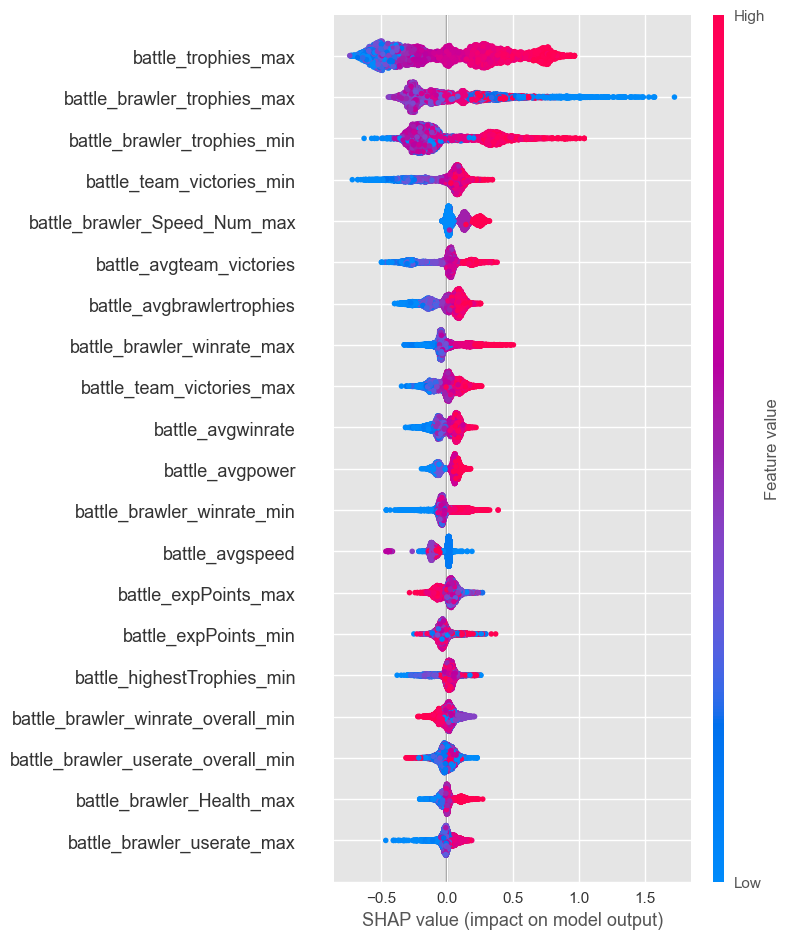

In [159]:
# interpret model
interpret_model(model_tuned)

In [160]:
plot_model(model_tuned, plot='confusion_matrix', save=True)
plot_model(model_tuned, plot='feature', save=True)
plot_model(model_tuned, plot='calibration', save=True)

'Calibration Curve.png'

In [85]:
# finalizar modelo
model_finalized = finalize_model(model_tuned)
predictions = predict_model(model_finalized, data = test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.6488,0.7076,0.6939,0.6524,0.6725,0.2948,0.2954


In [ ]:
# create_app(model_finalized)

In [86]:
save_model(model_finalized, 'models/catboost')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='winner',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                 ('feature_select',
                  Advanced_Feature_Selection_Classic(ml_usecase='classification',
                                                     n_jobs=-1,
                                                     random_state=4260,
                    

In [87]:
predictions.to_csv('/Users/alniquia/OneDrive - Telefonica/Documents/Projects/BrawlStars_Model/datasets/predictions/predictions_lc.csv')